# Installation of Required Modules 

In [ ]:
!pip install pgeocode

# Importing Basic Modules 


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from os import path

# Required ML Modules 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn import tree

# Loading files...

In [303]:
PATH= '/content/drive/MyDrive/colab_notebooks/Zest/hwk_ds.xlsx'
xls = pd.ExcelFile(PATH)
app_data = pd.read_excel(xls, 'application_data')
loan_perf = pd.read_excel(xls, 'loan_performance')

In [304]:
loan_perf['flgGood'].value_counts()

# The problem is not a hghly imbalanced classification problem

Good    769
Bad     516
Name: flgGood, dtype: int64

In [305]:
loan_perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   idLoan   1285 non-null   object
 1   flgGood  1285 non-null   object
dtypes: object(2)
memory usage: 20.2+ KB


In [306]:
print("number of features = ", len(app_data.columns))

number of features =  31


In [307]:
app_data['payment_ach'].value_counts()
# Payment_ach might not be useful

True     646
False      1
Name: payment_ach, dtype: int64

In [308]:
app_data['customer_id'].value_counts()[app_data['customer_id'].value_counts()>1]

# No mutiple data in the application table. No customer applied for mutiple loans

Series([], Name: customer_id, dtype: int64)

# Cleaning the loan data to be merged to a master data table

In [309]:
# Checking if the '-02' idLoan values have any preferences

check_df=pd.DataFrame()

for i in loan_perf['idLoan']:
  if '-02' in i:
    check_df=pd.concat([check_df, loan_perf[loan_perf['idLoan']==i]])

check_df['flgGood'].value_counts()


Good    13
Bad      3
Name: flgGood, dtype: int64

In [310]:
# Checking there aren't any duplicate values in the loan performance which could be classified as good and bad.
# Removing the '-02' and '-01' from the idLoan and drop the duplicates if they have mixed values

loan_perf['idLoan']=loan_perf['idLoan'].apply(lambda x: x.split('-')[0]).str.lower()
multi_appearance=loan_perf['idLoan'].value_counts()[loan_perf['idLoan'].value_counts()>1]
multi_appearance

# Multiple data with same id in the loan performance table

b3f9914dbb    2
b86063bf54    2
dfb2f1ec63    2
a15e74274b    2
d06841c8cf    2
0f9800a7ff    2
418abe2912    2
b4f2e3f3a3    2
b1a2837477    2
d7001aa34e    2
34ddb612ce    2
ae03151fee    2
2ac47a61e0    2
b6514d8366    2
70409dc892    2
4dad1a9de6    2
Name: idLoan, dtype: int64

In [311]:
# A dummy dataframe to find the duplicated rows with same loan_id and then remove them if they have different values (Good & Bad)

check_df=loan_perf[loan_perf.duplicated(subset='idLoan', keep=False)].sort_values(by='idLoan')

remove_ids=[]

for index, row in check_df.iterrows():
  if row['flgGood'] == 'Bad':
    remove_ids.append(row['idLoan'])

remove_ids=pd.Series(remove_ids)
print('Loan IDs with multiple output labels, \n', remove_ids)

Loan IDs with multiple output labels, 
 0    b1a2837477
1    b3f9914dbb
2    dfb2f1ec63
dtype: object


In [312]:
# Removing the ids with different values

loan_perf=loan_perf[loan_perf['idLoan'].isin(remove_ids)==False]


In [313]:
# Dropping the duplicate loan ids of the same label.

loan_perf=loan_perf.drop_duplicates(subset='idLoan', keep='first')
loan_perf=loan_perf.rename(columns={'idLoan': 'customer_id', 'flgGood':'class'})


# Merging the data to a master data table

In [314]:
master_df=app_data.merge(loan_perf, how='left', on='customer_id')
master_df

,customer_id,amount_requested,birth_date,status,residence_rent_or_own,monthly_rent_amount,bank_account_direct_deposit,application_when,loan_duration,payment_ach,...,home_phone_type,other_phone_type,how_use_money,monthly_income_amount,raw_l2c_score,raw_FICO_telecom,raw_FICO_retail,raw_FICO_bank_card,raw_FICO_money,class
0,9ece67d6c5,500.0,1991-08-21,Approved,True,0.0,True,2010-10-16 14:06:05,3.0,True,...,Mobile,NaN,Other,1560.0,614.0,574.0,600.0,656.0,561.0,Good
1,5c2c402094,500.0,1990-07-24,Approved,True,0.0,False,2010-10-17 13:01:53,6.0,True,...,Mobile,NaN,Other,900.0,708.0,501.0,550.0,651.0,563.0,Bad
2,e6254cad30,400.0,1980-09-13,Approved,True,620.0,True,2010-10-17 19:52:34,6.0,True,...,Mobile,NaN,Other,1434.0,687.0,522.0,561.0,661.0,598.0,Good
3,49fb42f51d,500.0,1976-09-10,Approved,False,785.0,False,2010-10-18 07:05:00,4.0,True,...,Mobile,NaN,Other,1600.0,616.0,560.0,552.0,634.0,591.0,Bad
4,195fbe5739,300.0,1979-12-01,Approved,True,700.0,True,2010-10-19 10:58:40,4.0,True,...,Mobile,Home,Other,1360.0,681.0,603.0,654.0,659.0,636.0,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,0aeed95009,300.0,1981-10-15,Approved,True,0.0,True,2011-04-16 18:45:43,3.0,True,...,Mobile,Work,Other,1600.0,616.0,583.0,591.0,680.0,622.0,Bad
643,755f6707c9,800.0,1946-03-06,Approved,True,529.0,True,2011-04-16 21:48:37,8.0,True,...,Mobile,Work,Other,2050.0,583.0,612.0,649.0,659.0,628.0,Good
644,9e9ca8f361,800.0,1976-05-25,Approved,True,900.0,True,2011-04-17 11:24:27,8.0,True,...,Mobile,NaN,Bills (Home / Utilities),3626.0,573.0,543.0,556.0,657.0,588.0,Good
645,0f7b7c2c37,500.0,1960-06-09,Approved,True,650.0,True,2011-04-17 12:06:13,5.0,True,...,Mobile,Work,Bills (General),1800.0,329.0,571.0,616.0,650.0,618.0,Bad


# Cleaning the master application data 

In [315]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 646
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   customer_id                  647 non-null    object        
 1   amount_requested             647 non-null    float64       
 2   birth_date                   647 non-null    datetime64[ns]
 3   status                       647 non-null    object        
 4   residence_rent_or_own        647 non-null    bool          
 5   monthly_rent_amount          647 non-null    float64       
 6   bank_account_direct_deposit  647 non-null    bool          
 7   application_when             647 non-null    datetime64[ns]
 8   loan_duration                647 non-null    float64       
 9   payment_ach                  647 non-null    bool          
 10  num_payments                 647 non-null    float64       
 11  payment_amount               647 non-null    

In [316]:
# Dropping all rows where there're no class labels

master_df=master_df[~master_df['class'].isnull()].reset_index(drop=True)
print(master_df.shape)
master_df.head()

(631, 32)


,customer_id,amount_requested,birth_date,status,residence_rent_or_own,monthly_rent_amount,bank_account_direct_deposit,application_when,loan_duration,payment_ach,...,home_phone_type,other_phone_type,how_use_money,monthly_income_amount,raw_l2c_score,raw_FICO_telecom,raw_FICO_retail,raw_FICO_bank_card,raw_FICO_money,class
0,9ece67d6c5,500.0,1991-08-21,Approved,True,0.0,True,2010-10-16 14:06:05,3.0,True,...,Mobile,NaN,Other,1560.0,614.0,574.0,600.0,656.0,561.0,Good
1,5c2c402094,500.0,1990-07-24,Approved,True,0.0,False,2010-10-17 13:01:53,6.0,True,...,Mobile,NaN,Other,900.0,708.0,501.0,550.0,651.0,563.0,Bad
2,e6254cad30,400.0,1980-09-13,Approved,True,620.0,True,2010-10-17 19:52:34,6.0,True,...,Mobile,NaN,Other,1434.0,687.0,522.0,561.0,661.0,598.0,Good
3,49fb42f51d,500.0,1976-09-10,Approved,False,785.0,False,2010-10-18 07:05:00,4.0,True,...,Mobile,NaN,Other,1600.0,616.0,560.0,552.0,634.0,591.0,Bad
4,195fbe5739,300.0,1979-12-01,Approved,True,700.0,True,2010-10-19 10:58:40,4.0,True,...,Mobile,Home,Other,1360.0,681.0,603.0,654.0,659.0,636.0,Good


In [317]:
# The refined version of the application data to be mpdified for model building

master_df_ref=master_df.copy()

# Feature Engineering

In [318]:
# Helper function to get the bank name 

import requests
import json
import ast

def get_routing_api(routing_number):
  try:
    response_API = requests.get('https://www.routingnumbers.info/api/data.json?rn={0}'.format(routing_number))
    data = response_API.text
    return ast.literal_eval(data)['customer_name']
  except:
    return np.nan

## Get the bank names from the routing number. API call is slow, so don't run unnecessarily.
## Uncomment the below code to run

In [319]:
# master_df_ref['bank_name']=master_df_ref['bank_routing_number'].astype(int).apply(lambda x: get_routing_api(x))
# Write the dataframe to a pickle file for storage and later usage. 
# master_df_ref.to_pickle('dataframe_after_API_call_new.pkl')

In [320]:
# Modifying zipcode to get the county names

import pgeocode
data = pgeocode.Nominatim('US')
# data.query_postal_code("94605")['county_name']

master_df_ref['county_name']=data.query_postal_code(master_df_ref['address_zip'].astype(int).astype(str).tolist())['county_name']


In [321]:
# Might be a useless variable try, get email

master_df_ref['email_prov']=master_df_ref['email'].apply(lambda x: x.split('@')[1].split('.com')[0])

## Load the already saved dataframe from pickle file to save running time

In [2]:
# Read the dataframe from a pickle file

PATH= '/content/drive/MyDrive/colab_notebooks/Zest/dataframe_after_API_call_new.pkl'
master_df_ref=pd.read_pickle(PATH)

In [3]:
# Convert birthdate to age

master_df_ref['age'] = (master_df_ref['application_when'] - master_df_ref['birth_date']).dt.days/365.0
master_df_ref['apply_time_since'] = (pd.datetime.today() - master_df_ref['application_when']).dt.days/365.0
master_df_ref['loan_duration_diff']=master_df_ref['loan_duration']-master_df_ref['duration_approved']
master_df_ref['amount_diff']=master_df_ref['amount_requested']-master_df_ref['amount_approved']
master_df_ref['monthly_income_balance']=master_df_ref['monthly_income_amount']-master_df_ref['monthly_rent_amount']
master_df_ref['payment_amount_approved'].fillna(master_df_ref['payment_amount_approved'].median(), inplace=True)
master_df_ref['payment_amount_diff']=master_df_ref['payment_amount']-master_df_ref['payment_amount_approved']

# Splitting datetime to new meaningful features: year, month, dayofweek, hour, time since application

master_df_ref['application_when_year']=master_df_ref['application_when'].dt.year
master_df_ref['application_when_month']=master_df_ref['application_when'].dt.month
master_df_ref['application_when_dow']=master_df_ref['application_when'].dt.dayofweek
master_df_ref['application_when_hour']=master_df_ref['application_when'].dt.hour

# Drop the status, payment_ach as they have a singular value.

master_df_ref.drop(columns=['status', 'customer_id', 'payment_ach', 'monthly_income_amount', 'bank_routing_number', 'address_zip', 'email', 'birth_date', 'application_when', 'loan_duration', 'amount_requested', 'payment_amount_approved', 'county_name', 'bank_name'], inplace=True)

master_df_ref.shape

(631, 31)

In [4]:
# Checking if any features are obviously good! I love cross tab

df=master_df_ref
good_df = df[df['class'] == 'Good']
good_len=len(good_df)
bad_df = df[df['class'] == 'Bad'][:good_len]

balanced_df = pd.concat([good_df, bad_df]).sample(frac=1, random_state=42)

# master_df_ref['loan_duration_diff']
pd.crosstab(balanced_df.loan_duration_diff, balanced_df['class']) #

class,Bad,Good
loan_duration_diff,,
0.0,228,232
1.0,4,1
2.0,49,48


In [5]:
master_df_ref=master_df_ref.sample(frac=1.)
master_df_ref.reset_index(drop=True, inplace=True)

In [6]:
ori_df_cols=['age','raw_l2c_score',
      'raw_FICO_telecom', 'raw_FICO_retail', 'raw_FICO_bank_card',
      'raw_FICO_money']

In [7]:
# Splitting of dataset to avoid leakage.

train=master_df_ref.sample(frac = 0.8, random_state=8) #np.random.RandomState()
test = master_df_ref.drop(train.index)
# train=train.sample(frac = 10, random_state=np.random.RandomState(), replace=True)

# Checking the balance of classes

Good fraction in the data : 45.940594059405946
Bad fraction in the data : 54.05940594059406


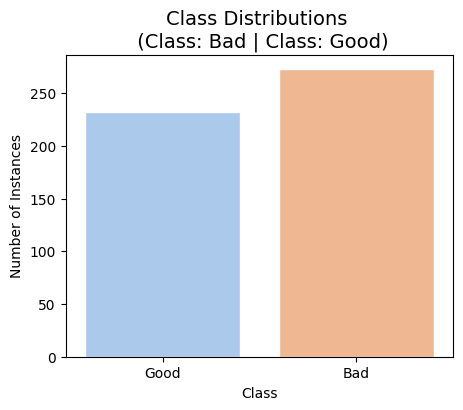

In [8]:
# Class balance
fig, axes = plt.subplots(1, 1, figsize=(5,4), dpi=100)
print('Good fraction in the data :',len(train[train['class']=='Good'])/len(train)*100)
print('Bad fraction in the data :',len(train[train['class']=='Bad'])/len(train)*100)

sns.set_theme(style="white", palette="pastel")
g=sns.countplot(data=train, x='class')
plt.xlabel('Class')
plt.ylabel('Number of Instances')

plt.title('Class Distributions \n (Class: Bad | Class: Good)', fontsize=14)
plt.show()

In [9]:
# Testing categorical encoding manually

# Train - Feature engineering: imputation, missing values, encoding.

train['bank_account_duration'].fillna(train['bank_account_duration'].mode()[0], inplace=True)
train['other_phone_type'].fillna('NA', inplace=True)
train['how_use_money'].fillna(train['how_use_money'].mode()[0], inplace=True)
# train['bank_name'].fillna('NA', inplace=True)

# Encoding categorical variables manually.

train['email_duration']=train['email_duration'].map({ '3 months or less':1, '4-12 months':2, '1 year or more':3})
train['residence_duration']=train['residence_duration'].map({'6 months or less':1, '7-12 months':2, '1-2 years':3, '3+ years':4})
train['bank_account_duration']=train['bank_account_duration'].map({'6 months or less':1, '7-12 months':2, '1-2 years':3, '3+ years':4})
train['payment_frequency']=train['payment_frequency'].map({'Weekly':52, 'Bi-weekly':26, 'Semi-monthly':24, 'Monthly':12})

train_cat = train.select_dtypes(include = 'object').copy()
train_num = train.select_dtypes(include = 'number').copy()
train_bool= train.select_dtypes(include = 'bool').copy()

for column in train_bool.columns.tolist():
  train[column]=train[column].astype(int)
# train.info()

In [10]:
# Outlier removal based on quantile values for training data

outlier_check= ['monthly_rent_amount', 'monthly_income_balance', 'payment_amount', 'amount_approved', 'raw_l2c_score',	'raw_FICO_telecom',	'raw_FICO_retail',	'raw_FICO_bank_card',	'raw_FICO_money']

for i in outlier_check:
  train[i]=train[i][(train[i] <= train[i].quantile(0.90)) | (train[i] >= train[i].quantile(0.10))]


In [11]:
# Test - Feature engineering: imputation, missing values, encoding.

test['bank_account_duration'].fillna(test['bank_account_duration'].mode()[0], inplace=True)
test['other_phone_type'].fillna('NA', inplace=True)
test['how_use_money'].fillna(test['how_use_money'].mode()[0], inplace=True)
# test['bank_name'].fillna('NA', inplace=True)

# Encoding categorical variables manually.

test['email_duration']=test['email_duration'].map({ '3 months or less':1, '4-12 months':2, '1 year or more':3})
test['residence_duration']=test['residence_duration'].map({'6 months or less':1, '7-12 months':2, '1-2 years':3, '3+ years':4})
test['bank_account_duration']=test['bank_account_duration'].map({'6 months or less':1, '7-12 months':2, '1-2 years':3, '3+ years':4})
test['payment_frequency']=test['payment_frequency'].map({'Weekly':52, 'Bi-weekly':26, 'Semi-monthly':24, 'Monthly':12})

test_cat = test.select_dtypes(include = 'object').copy()
test_num = test.select_dtypes(include = 'number').copy()
test_bool= test.select_dtypes(include = 'bool').copy()

for column in test_bool.columns.tolist():
  test[column]=test[column].astype(int)


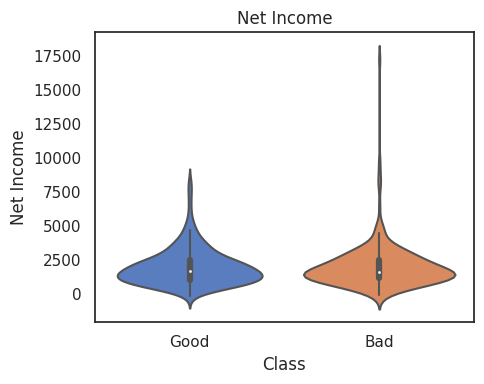

In [12]:
# Check violin plots for each feature

fig, axes = plt.subplots(1, 1, figsize=(5,4), dpi=100)

sns.violinplot(ax=axes, data=train, x='class', y="monthly_income_balance", palette="muted", split=True, order=["Good", "Bad"])
axes.set_title ('Net Income')
axes.set_ylabel('Net Income')
axes.set_xlabel('Class')
plt.tight_layout()
plt.show()

In [13]:
## One Hot Encoding

#ohe_cols=train.nunique()[train.nunique()<5].index
#ohe_cols=[col for col in ohe_cols if col!='class']
#new_train=train[ohe_cols]
#new_train=pd.get_dummies(new_train, columns=ohe_cols)
#train=train.drop(columns=ohe_cols).join(new_train)
#
#new_test=test[ohe_cols]
#new_test=pd.get_dummies(new_test, columns=ohe_cols)
#test=test.drop(columns=ohe_cols).join(new_test)

## Checking if year, month or other have an effect on classes: univariate analysis 

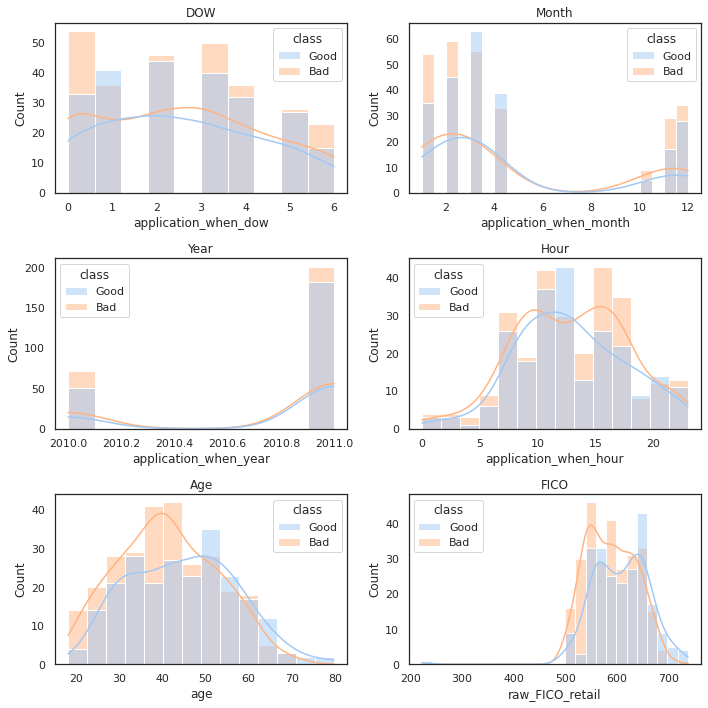

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

sns.histplot(x=train["application_when_dow"], hue=train["class"], multiple='layer', kde=True,  ax=axes[0,0])
axes[0,0].set_title('DOW')

sns.histplot(x=train["application_when_month"], hue=train["class"], multiple='layer', kde=True, ax=axes[0,1])
axes[0,1].set_title('Month')

sns.histplot(x=train["application_when_year"], hue=train["class"], multiple='layer', kde=True, ax=axes[1,0])
axes[1,0].set_title('Year')

sns.histplot(x=train["application_when_hour"], hue=train["class"], multiple='layer', kde=True, ax=axes[1,1])
axes[1,1].set_title('Hour')

sns.histplot(x=train["age"], hue=train["class"], multiple='layer', kde=True, ax=axes[2,0])
axes[2,0].set_title('Age')

sns.histplot(x=train["raw_FICO_retail"], hue=train["class"], multiple='layer', kde=True, ax=axes[2,1])
axes[2,1].set_title('FICO')

plt.tight_layout()
plt.show()

In [15]:
# Train - Encoding categorical variables with sklearn ordinal encoder.

cat_df = train.select_dtypes(include=['object']).copy() 

enc_make = OrdinalEncoder()

cat_df_fit_data = pd.concat([train, test]).select_dtypes(include=['object']).copy() # Encoding fitting needs to be done for all the dataset so that we have labels consistent.

enc_make.fit(cat_df_fit_data)
cat_df_transformed = enc_make.transform(cat_df)

for i,j in enumerate(cat_df.columns):
  cat_df[j] = cat_df_transformed.transpose()[i]

# Adding converted labels to df
for i in train.columns:
  if i in cat_df.columns and i!='class':
    train[i] = cat_df[i]

# Scaling of data

mm_scaler = MinMaxScaler()
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

for i in train.columns:
  if i!='class':
    train[i] = rob_scaler.fit_transform(train[i].values.reshape(-1,1))
train=train[[c for c in train if c not in ['class']] + ['class']]


In [16]:
# Test - Encoding categorical variables, do if needed. Otherwise just go with sklearn ordinal encoder.

cat_df = test.select_dtypes(include=['object']).copy()

cat_df_transformed = enc_make.transform(cat_df)

for i,j in enumerate(cat_df.columns):
  cat_df[j] = cat_df_transformed.transpose()[i]

# Adding converted labels to df
for i in test.columns:
  if i in cat_df.columns and i!='class':
    test[i] = cat_df[i]

# Scaling of data

mm_scaler = MinMaxScaler()
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

for i in test.columns:
  if i!='class':
    test[i] = rob_scaler.fit_transform(test[i].values.reshape(-1,1))

test=test[[c for c in test if c not in ['class']] + ['class']]

# Boxplot of features and classes

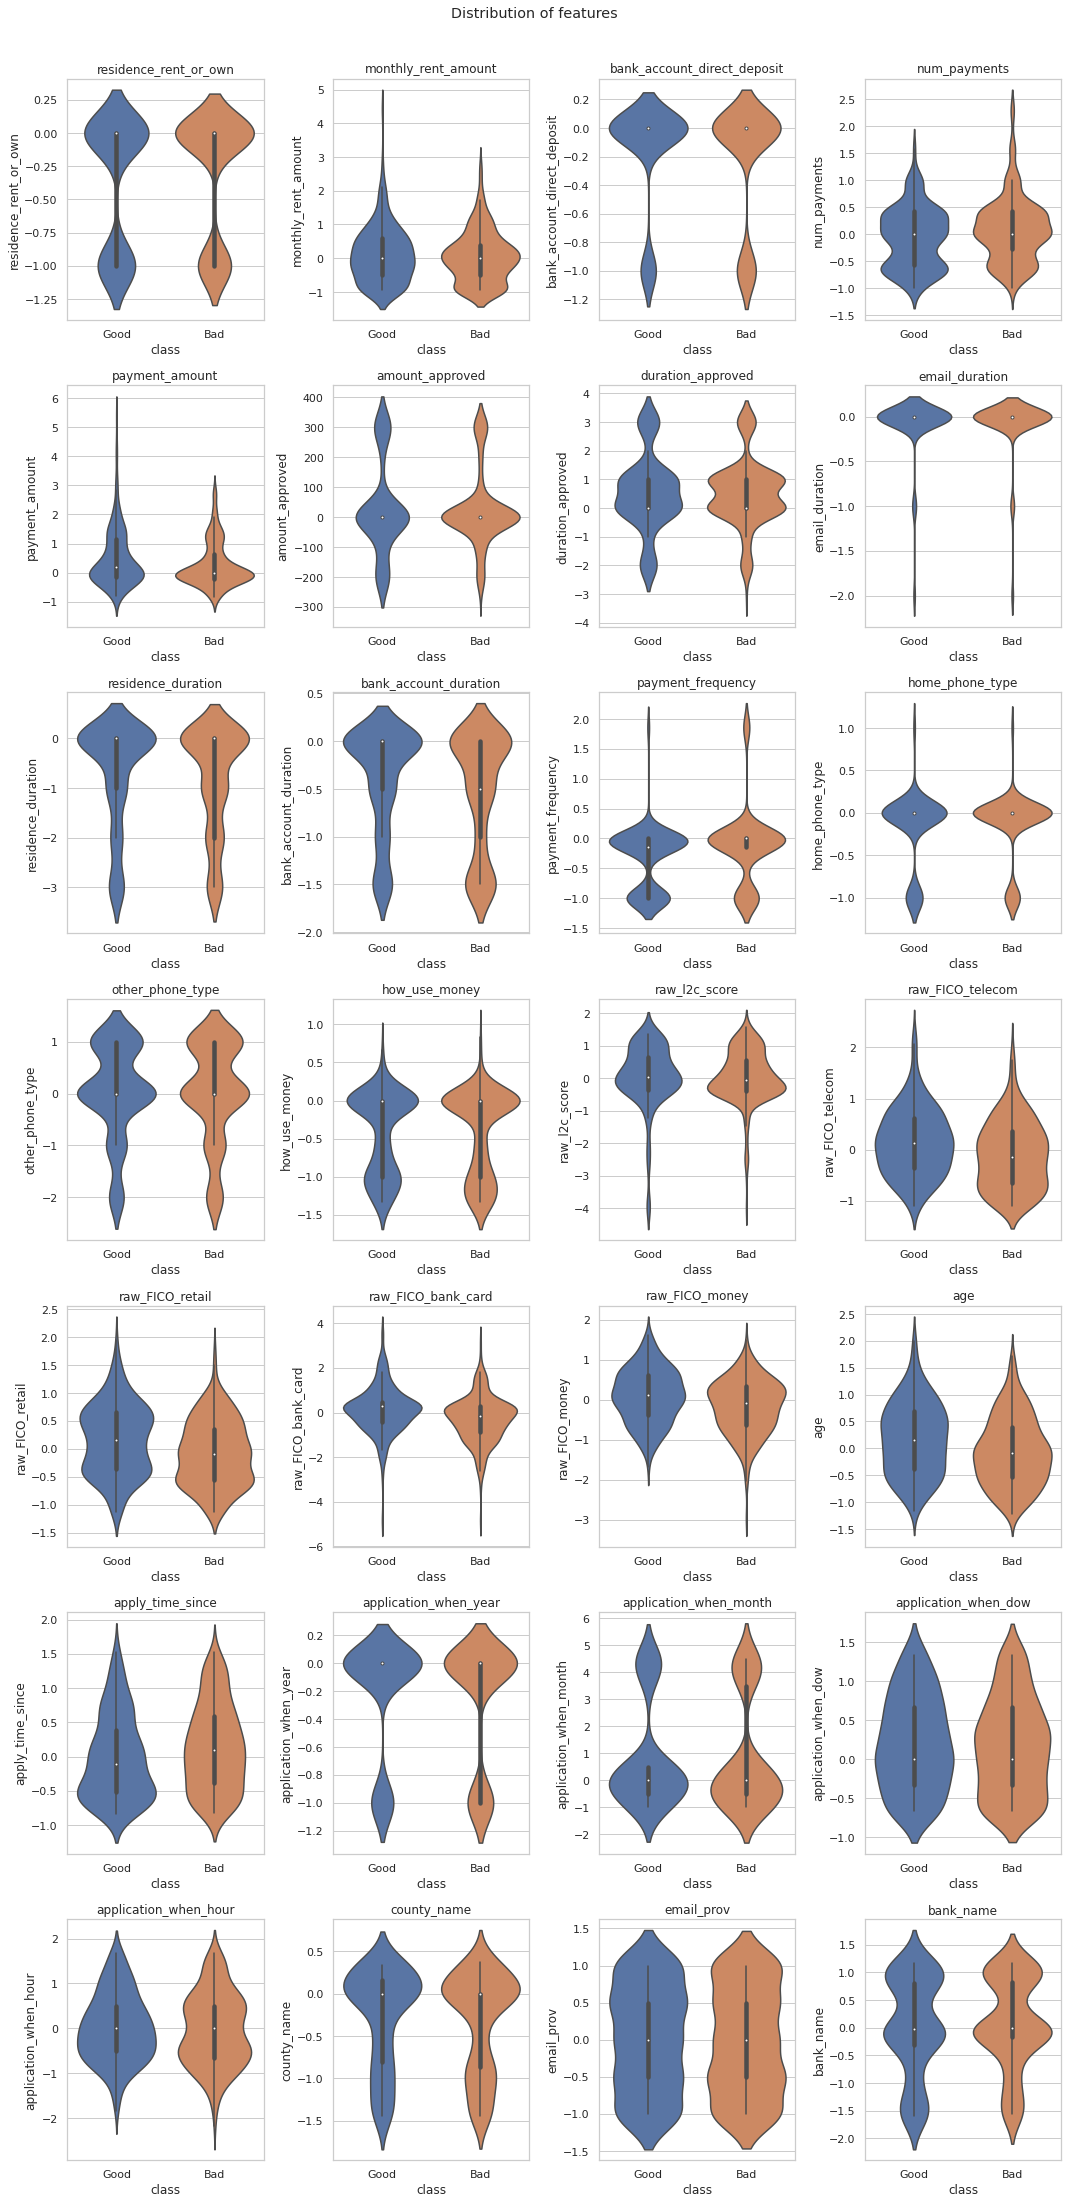

In [194]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(7, 4, figsize=(15, 30))
fig.suptitle('Distribution of features', y=1.02)

count=0
for i in range(7):
    for j in range(4):
        sns.violinplot(ax=axes[i, j], data=train, x='class', y=train.columns[count])
        axes[i,j].set_title(train.columns[count])
        count+=1
plt.tight_layout()

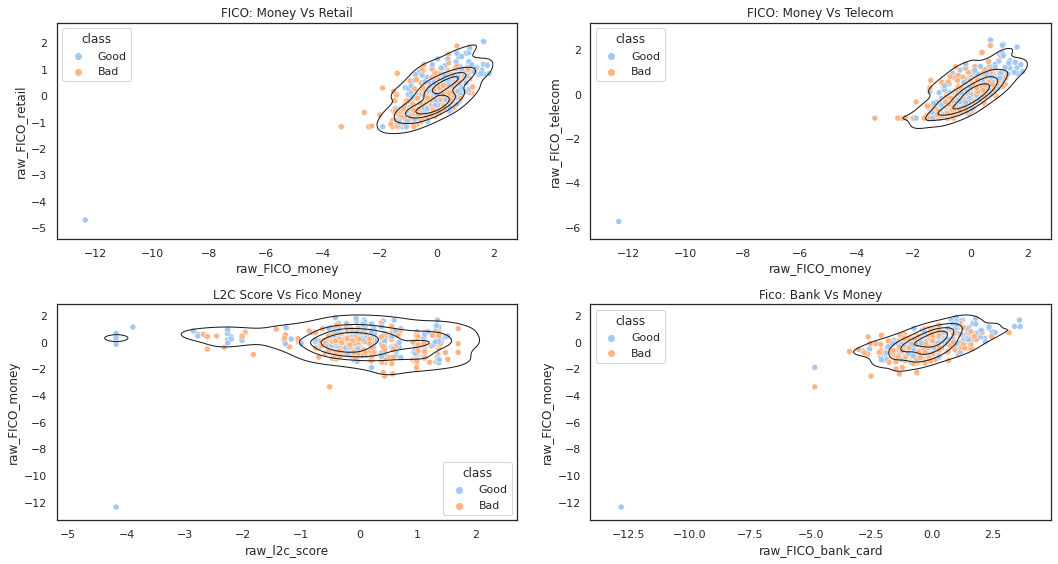

In [132]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

sns.scatterplot(x=train["raw_FICO_money"], y=train["raw_FICO_retail"], hue=train["class"], ax=axes[0,0])
sns.kdeplot(x=train["raw_FICO_money"], y=train["raw_FICO_retail"], levels=5, color="k", linewidths=1, ax=axes[0,0])
axes[0,0].set_title('FICO: Money Vs Retail')

sns.scatterplot(x=train["raw_FICO_money"], y=train['raw_FICO_telecom'], hue=train["class"], ax=axes[0,1])
sns.kdeplot(x=train["raw_FICO_money"], y=train['raw_FICO_telecom'], levels=5, color="k", linewidths=1, ax=axes[0,1])
axes[0,1].set_title('FICO: Money Vs Telecom')

sns.scatterplot(x=train['raw_l2c_score'], y=train['raw_FICO_money'], hue=train["class"], ax=axes[1,0])
sns.kdeplot(x=train['raw_l2c_score'], y=train['raw_FICO_money'], levels=5, color="k", linewidths=1, ax=axes[1,0])
axes[1,0].set_title('L2C Score Vs Fico Money')

sns.scatterplot(x=train['raw_FICO_bank_card'], y=train['raw_FICO_money'], hue=train["class"], ax=axes[1,1])
sns.kdeplot(x=train['raw_FICO_bank_card'], y=train['raw_FICO_money'], levels=5, color="k", linewidths=1, ax=axes[1,1])
axes[1,1].set_title('Fico: Bank Vs Money')

plt.tight_layout()
plt.show()

In [17]:
# Encode class labels

train['class']=train['class'].map({'Good':1, 'Bad':0})
test['class']=test['class'].map({'Good':1, 'Bad':0})

# Visuals of feature correlation and distributions

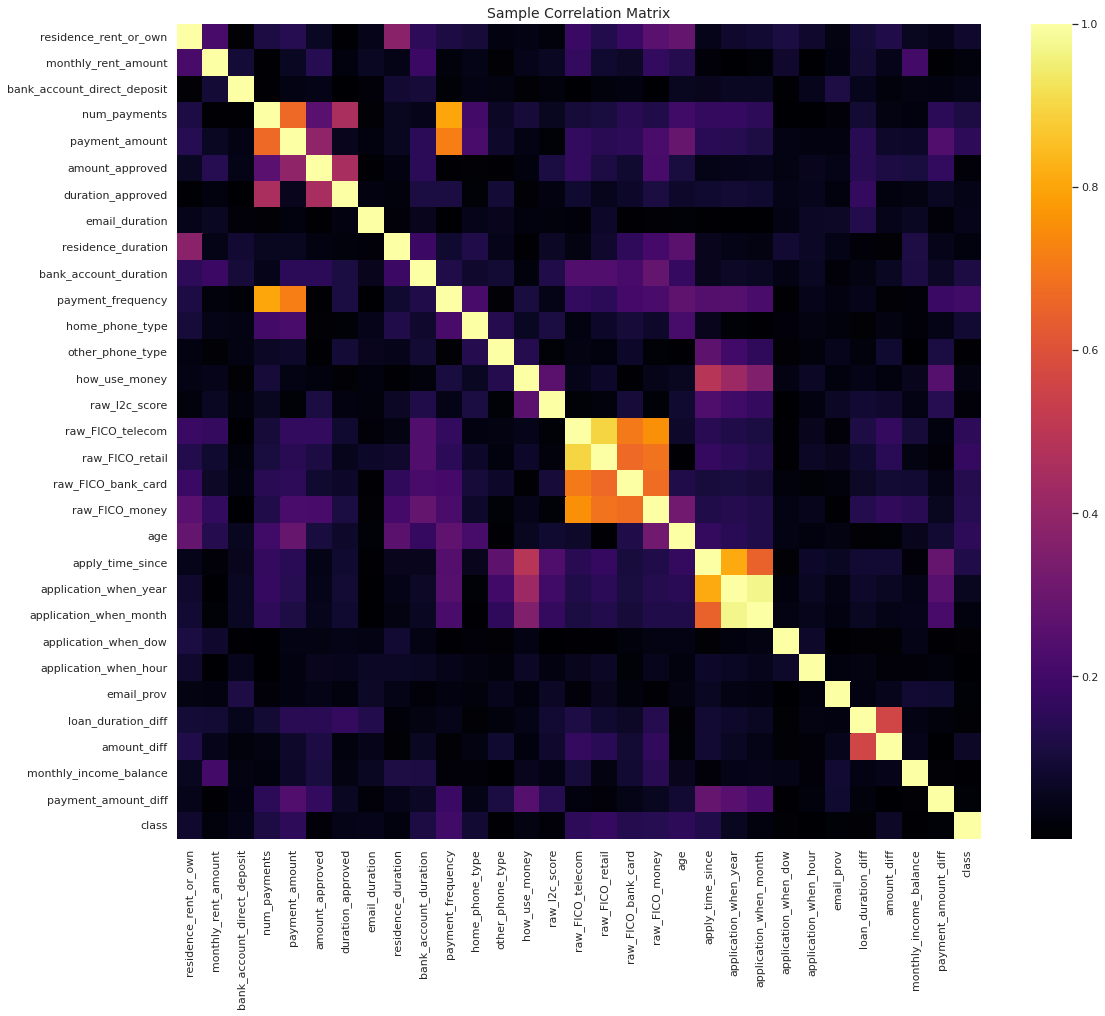

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(18,15))

# Sub-sample dataframe
sub_sample_corr = train.corr().abs()
sns.heatmap(sub_sample_corr, cmap='inferno', ax=axes)
axes.set_title('Sample Correlation Matrix', fontsize=14)
plt.show()

In [19]:
# Highly correlated features: greater than 90%

corr=train.corr().abs()[(train.corr().abs()>0.9) & (train.corr().abs()!=1.0)]
corr[~corr.isnull()].dropna(axis=1, how='all').dropna(axis=0, how='all')


,application_when_year,application_when_month
application_when_year,NaN,0.969428
application_when_month,0.969428,NaN


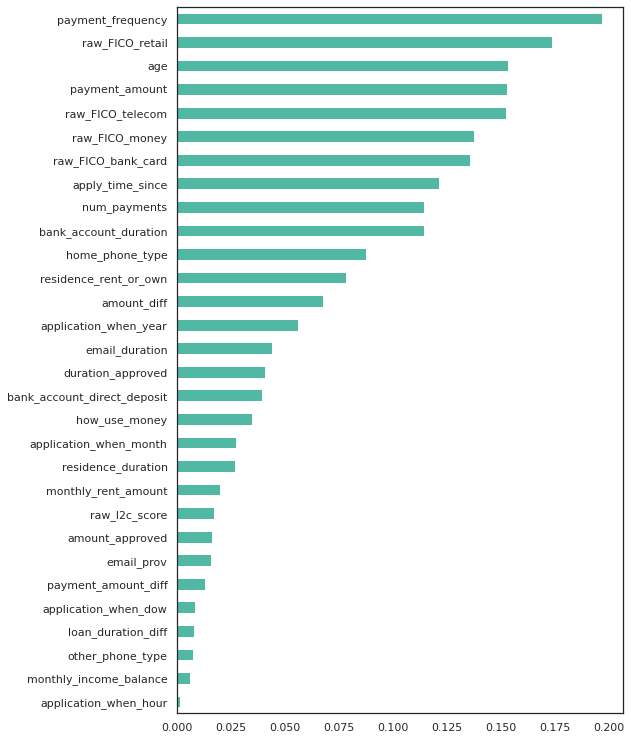

In [20]:
# Highest correlated features with target

feat_corr=train.corr()['class'].abs().sort_values(ascending=True)[:-1]
fig, axes = plt.subplots(1, 1, figsize=(8,13))
feat_corr.plot.barh(color='#51b9a3')
plt.show()

# Drop 'payment_amount' and 'month'

In [21]:
# Splitting the data for training and testing

X_train = train.drop(columns = ['class']) 
y_train = train['class']

X_test = test.drop(columns = ['class']) 
y_test = test['class']

print('Training data: \nX shape -', X_train.shape)
print('y shape -', y_train.shape, '\n')

print('Testing data: \nX shape -', X_test.shape)
print('y shape -', y_test.shape)


Training data: 
X shape - (505, 30)
y shape - (505,) 

Testing data: 
X shape - (126, 30)
y shape - (126,)


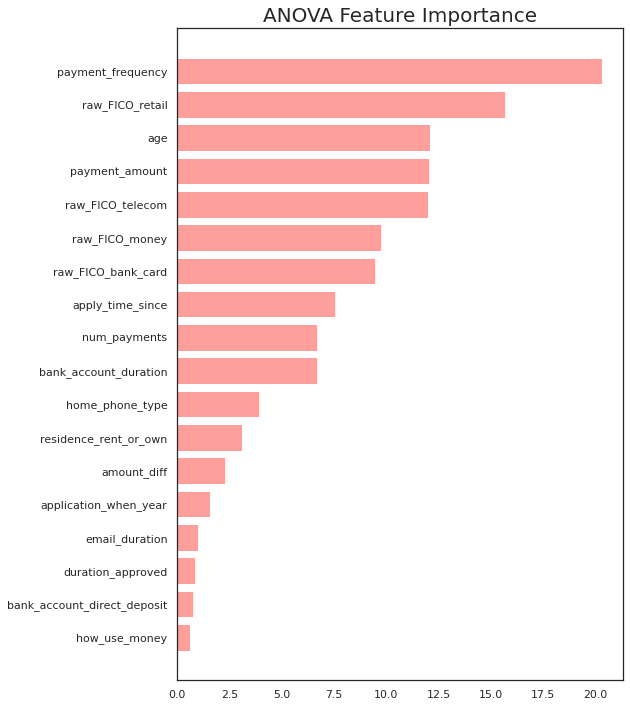

In [22]:
# ANOVA F-classif feature selection for categorical data
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, SelectFpr, f_classif

# feature selection
def select_features(X_train, y_train, X_test):
  fs = SelectKBest(score_func=f_classif, k=5)
  fs.fit(X_train, y_train)
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

feature_dict={}
# what are scores for the features
for i in range(len(fs.scores_)):
  feature_dict[fs.scores_[i]]=X_train.columns[i]

# for key in sorted(feature_dict, reverse=True):
    # print("%.3f: %s" % (np.round(key, decimals=3), feature_dict[key]))
feature_dict = {v:k for (k,v) in feature_dict.items() if k > 0.5} # k:v
feature_dict = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1], reverse=False)}
selected_features=list(feature_dict.keys())

# plot the scores
fig, axes = plt.subplots(1, 1, figsize=(8, 12))
plt.barh(*zip(*feature_dict.items()), color='r')
plt.xticks(rotation=0)
plt.title('ANOVA Feature Importance', fontsize=20)
plt.show()

# Feature importance influenced features

# X_train=X_train[selected_features]
# X_test=X_test[selected_features]


In [23]:
# Dropping a few unimportant features

X_train.drop(columns=['application_when_month'], inplace=True, errors='ignore')
X_test.drop(columns=['application_when_month'], inplace=True, errors='ignore')

X_train.shape

(505, 29)

# Checking the effect of dimensions

In [274]:
# Dimensionality Reduction Analysis
# Check if dimensionality makes. adifference to the scores.

def dim_score(X_train, y_train, X_test, y_test, d=2):
  from sklearn import decomposition
  from sklearn.decomposition import PCA
  pca = decomposition.PCA(n_components=d) 
  pca.fit(X_train)
  X_train = pca.transform(X_train)
  X_test = pca.transform(X_test)
  # print(X_train.shape)
  # print(X_test.shape)
  label_encoded_y_train = LabelEncoder().fit_transform(y_train)
  label_encoded_y_test = LabelEncoder().fit_transform(y_test)
  clf = RandomForestClassifier(n_estimators=500, max_depth=25, random_state=None)
  clf = clf.fit(X_train, label_encoded_y_train)
  y_pred = clf.predict(X_test)
  accuracy=clf.score(X_test, label_encoded_y_test)
  f1score=f1_score(label_encoded_y_test, y_pred)
  aucscore=roc_auc_score(label_encoded_y_test, y_pred)
  # print("Accuracy = ", clf.score(X_test, label_encoded_y_test))
  # print('F1 score = ', f1_score(label_encoded_y_test, y_pred))
  # print('AUC Score = ', roc_auc_score(label_encoded_y_test, y_pred))
  return X_train, X_test


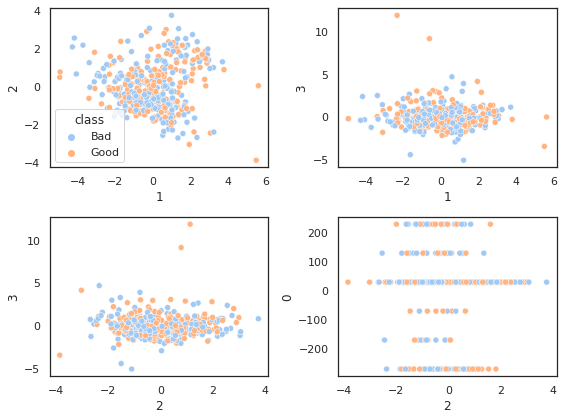

In [311]:
plot_X_train, plot_X_test=dim_score(X_train, y_train, X_test, y_test, d=4)
plot_X_train=pd.DataFrame(plot_X_train)
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

sns.scatterplot(x=plot_X_train[1], y=plot_X_train[2], hue=y_train, ax=axes[0,0])
sns.scatterplot(x=plot_X_train[1], y=plot_X_train[3], hue=y_train, ax=axes[0,1])
sns.scatterplot(x=plot_X_train[2], y=plot_X_train[3], hue=y_train, ax=axes[1,0])
sns.scatterplot(x=plot_X_train[2], y=plot_X_train[0], hue=y_train, ax=axes[1,1])
axes[0,1].get_legend().remove()
axes[1,0].get_legend().remove()
axes[1,1].get_legend().remove()
plt.tight_layout()
plt.show()

# Functions that incorporate all the pre-processing and outputs the train and test data


In [39]:
def feat_eng(df):
  # Missing value
  df['bank_account_duration'].fillna(df['bank_account_duration'].mode()[0], inplace=True)
  df['other_phone_type'].fillna('NA', inplace=True)
  df['how_use_money'].fillna(df['how_use_money'].mode()[0], inplace=True)
  df['bank_name'].fillna('NA', inplace=True)
  df['payment_amount_approved'].fillna(df['payment_amount_approved'].median(), inplace=True)
  # Manual Encoding 
  df['email_duration']=df['email_duration'].map({ '3 months or less':1, '4-12 months':2, '1 year or more':3})
  df['residence_duration']=df['residence_duration'].map({'6 months or less':1, '7-12 months':2, '1-2 years':3, '3+ years':4})
  df['bank_account_duration']=df['bank_account_duration'].map({'6 months or less':1, '7-12 months':2, '1-2 years':3, '3+ years':4})
  df['payment_frequency']=df['payment_frequency'].map({'Weekly':52, 'Bi-weekly':26, 'Semi-monthly':24, 'Monthly':12})
  df_cat = df.select_dtypes(include = 'object').copy()
  df_num = df.select_dtypes(include = 'number').copy()
  df_bool= df.select_dtypes(include = 'bool').copy()
  for column in df_bool.columns.tolist():
    df[column]=df[column].astype(int)
  return df

def rob_scale(df):
  mm_scaler = MinMaxScaler()
  std_scaler = StandardScaler()
  rob_scaler = RobustScaler()
  for i in df.columns:
    if i!='class':
      df[i] = rob_scaler.fit_transform(df[i].values.reshape(-1,1))
  return df

def processed_for_model(PATH, randoms=5, frac=0.8):
  
  # Loading pre-saved data after running APIs for Feature engineering
  PATH= '/content/drive/MyDrive/colab_notebooks/Zest/dataframe_after_API_call_new.pkl'
  df=pd.read_pickle(PATH) 
  
  # New features
  df['monthly_income_balance']=df['monthly_income_amount']-df['monthly_rent_amount']
  df.drop(columns=['status', 'customer_id', 'payment_ach', 'monthly_income_amount', 'bank_routing_number', 'address_zip', 'email', 'birth_date', 'application_when'], inplace=True)
  
  # Shuffling the data
  df=df.sample(frac=1.0, random_state=randoms, replace=False)
  df.reset_index(drop=True, inplace=True)

  # Splitting data to avoid data leakage
  train=df.sample(frac = frac, random_state=randoms, replace=True) # call param
  test = df.drop(train.index)
  
  # Train - Feature engineering: imputation, missing values, encoding.
  train=feat_eng(train)

  # Outlier removal of numerical data in training
  outlier_check= ['amount_requested', 'monthly_rent_amount', 'monthly_income_balance', 'payment_amount', 'payment_amount_approved', 'amount_approved', 'raw_l2c_score',	'raw_FICO_telecom',	'raw_FICO_retail',	'raw_FICO_bank_card',	'raw_FICO_money']
  for i in outlier_check:
    train[i]=train[i][(train[i] <= train[i].quantile(0.90)) | (train[i] >= train[i].quantile(0.10))] 

  # Test - Feature engineering: imputation, missing values, encoding.
  test=feat_eng(test)

  # Train - Encoding categorical variables for train
  cat_df = train.select_dtypes(include=['object']).copy() 
  enc_make = OrdinalEncoder()
  cat_df_fit_data = pd.concat([train, test]).select_dtypes(include=['object']).copy() # Encoding fitting needs to be done for all the dataset so that we have labels consistent.
  enc_make.fit(cat_df_fit_data)
  cat_df_transformed = enc_make.transform(cat_df)
  for i,j in enumerate(cat_df.columns):
    cat_df[j] = cat_df_transformed.transpose()[i]
  for i in train.columns:
    if i in cat_df.columns and i!='class':
      train[i] = cat_df[i]

  # Test - Encoding categorical variables
  cat_df = test.select_dtypes(include=['object']).copy()
  cat_df_transformed = enc_make.transform(cat_df)
  for i,j in enumerate(cat_df.columns):
    cat_df[j] = cat_df_transformed.transpose()[i]
  for i in test.columns:
    if i in cat_df.columns and i!='class':
      test[i] = cat_df[i]

  # Scaling of training data
  train=rob_scale(train)

  # Scaling of testing data
  test=rob_scale(test)

  # Splitting the data for training and testing
  X_train = train.drop(columns = ['class']) 
  y_train = train['class']
  X_test = test.drop(columns = ['class']) 
  y_test = test['class']

  #Oversampling
  print(Counter(y_train)) # Class distribution
  oversample = RandomOverSampler(sampling_strategy='minority')
  # Fitting and applying the transforms
  X_train, y_train = oversample.fit_resample(X_train, y_train)
  # summarize class distribution
  print(Counter(y_train))
  print('X shape -', X_train.shape)
  print('y shape -', y_train.shape)

  # Dropping features
  X_train.drop(columns=['email_duration', 'home_phone_type', 'email_prov', 'payment_amount_approved'], inplace=True, errors='ignore')
  X_test.drop(columns=['email_duration', 'home_phone_type', 'email_prov', 'payment_amount_approved'], inplace=True, errors='ignore')
  return X_train, y_train, X_test, y_test


In [37]:
# For counter factual analysis

ori_df_cols=['raw_l2c_score',
      'raw_FICO_telecom', 'raw_FICO_retail', 'raw_FICO_bank_card',
      'raw_FICO_money']

ori_df_cols

['raw_l2c_score',
 'raw_FICO_telecom',
 'raw_FICO_retail',
 'raw_FICO_bank_card',
 'raw_FICO_money']

Counter({'Bad': 284, 'Good': 221})
Counter({'Good': 284, 'Bad': 284})
X shape - (568, 32)
y shape - (568,)
(568, 28)
(289, 28)
Accuracy: 0.615916955017301
F1 score 0.5355648535564854
AUC Score =  0.6085766423357665


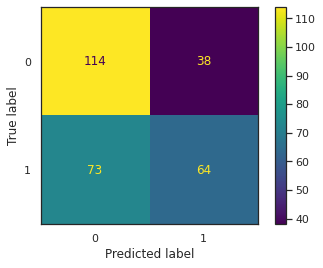

In [40]:
X_train, y_train, X_test, y_test=processed_for_model(PATH, 10, 0.8)
# Counterfactual
# X_train=X_train[ori_df_cols]
# X_test=X_test[ori_df_cols]

print(X_train.shape)
print(X_test.shape)
label_encoded_y_train = LabelEncoder().fit_transform(y_train)
label_encoded_y_test = LabelEncoder().fit_transform(y_test)

clf = RandomForestClassifier(n_estimators=200, criterion="entropy", max_depth=25, random_state=None) # gini, entropy, log_loss
clf = clf.fit(X_train, label_encoded_y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", clf.score(X_test, label_encoded_y_test))
print('F1 score', f1_score(label_encoded_y_test, y_pred))
print('AUC Score = ', roc_auc_score(label_encoded_y_test, y_pred))
plot_confusion_matrix(clf, X_test, label_encoded_y_test)

plt.show()

Counter({'Bad': 284, 'Good': 221})
Counter({'Good': 284, 'Bad': 284})
X shape - (568, 32)
y shape - (568,)
(568, 28)
(289, 28)
Accuracy: 0.5536332179930796
F1 score 0.6030769230769232
AUC Score =  0.561611601997695


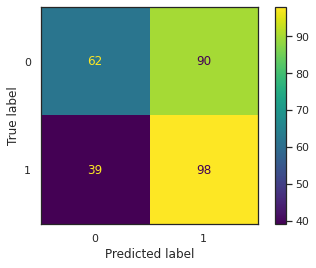

In [41]:
from sklearn.ensemble import AdaBoostClassifier
# Logistic Regression

X_train, y_train, X_test, y_test=processed_for_model(PATH, 10, 0.8)
# Counterfactual
# X_train=X_train[ori_df_cols]
# X_test=X_test[ori_df_cols]

print(X_train.shape)
print(X_test.shape)
label_encoded_y_train = LabelEncoder().fit_transform(y_train)
label_encoded_y_test = LabelEncoder().fit_transform(y_test)

clf=LogisticRegression()
# clf = AdaBoostClassifier(n_estimators=250, random_state=0)

clf = clf.fit(X_train, label_encoded_y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", clf.score(X_test, label_encoded_y_test))
print('F1 score', f1_score(label_encoded_y_test, y_pred))
print('AUC Score = ', roc_auc_score(label_encoded_y_test, y_pred))
plot_confusion_matrix(clf, X_test, label_encoded_y_test)  

plt.show()

# XGBoost Model performs the best in categorical data

# Hyperparameter tuning
## Step 1: learning rate and number of estimators

In [42]:
# Hyper parameter tuning of the XGBoost model using grid_search

X_train, y_train, X_test, y_test=processed_for_model(PATH, 10, 0.8)
# Counterfactual
# X_train=X_train[ori_df_cols]
# X_test=X_test[ori_df_cols]

from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot

# split data into X and y
X = X_train
y = y_train

# encode string class values as integers

le=LabelEncoder().fit(y)
label_encoded_y = le.transform(y)
label_encoded_y_test = le.transform(y_test)

# grid search
model = XGBClassifier(eta=0.01, gamma=1.0, reg_lambda=1, max_depth=10) # 

n_estimators = range(720, 740, 20)
# A parameter grid for XGBoost
param_grid = {'n_estimators': n_estimators,
        'eta':[0.05]}
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']


Counter({'Bad': 284, 'Good': 221})
Counter({'Good': 284, 'Bad': 284})
X shape - (568, 32)
y shape - (568,)
Best: 0.863627 using {'eta': 0.05, 'n_estimators': 720}


F1 score 0.5603112840466926
AUC Score =  0.6048789857856319


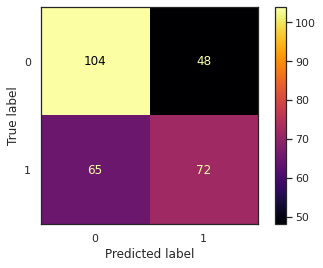

In [44]:
y_pred = grid_result.best_estimator_.predict(X_test)
label_encoded_y_test = LabelEncoder().fit_transform(y_test)
print('F1 score', f1_score(label_encoded_y_test, y_pred))

plot_confusion_matrix(grid_result.best_estimator_, X_test, label_encoded_y_test, cmap='inferno')  

print('AUC Score = ', roc_auc_score(label_encoded_y_test, y_pred))


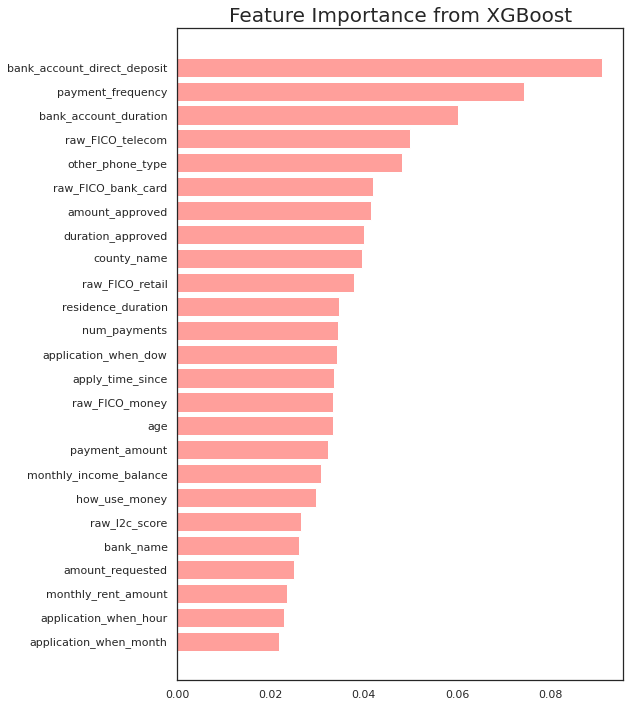

In [521]:
importance=grid_result.best_estimator_.feature_importances_
label_encoded_y_test = LabelEncoder().fit_transform(y_test)
feature_dict={}
# what are scores for the features
for i in range(len(importance)):
  feature_dict[importance[i]]=X_train.columns[i]

feature_dict = {v:k for (k,v) in feature_dict.items() if k>0.02} # k:v
feature_dict = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1], reverse=False)}
selected_features=list(feature_dict.keys())

# plot the scores
fig, axes = plt.subplots(1, 1, figsize=(8, 12))
plt.barh(*zip(*feature_dict.items()), color='r')
plt.xticks(rotation=0)
plt.title('Feature Importance from XGBoost', fontsize=20)
plt.show()

## Step 2: Tune max_depth and min_child_weight

In [43]:

# Hyper parameter tuning of the XGBoost model using grid_search

# grid search
model = XGBClassifier(n_estimators=720, eta=0.05)

# A parameter grid for XGBoost
param_grid = {'min_child_weight': [0.1, 0.2, 0.5],
              'max_depth': [5, 7, 8, 10]}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.855052 using {'max_depth': 10, 'min_child_weight': 0.5}


## Step 3: Tune gamma

In [509]:
# Hyper parameter tuning of the XGBoost model using grid_search

# grid search
model = XGBClassifier(n_estimators=440, eta=0.05, max_depth=8, min_child_weight=0.5)

# A parameter grid for XGBoost
param_grid = {'gamma': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 1.5]}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.855374 using {'gamma': 0.05}


## Step 4: Tune subsample and colsample_bytree

In [511]:
# Hyper parameter tuning of the XGBoost model using grid_search

# grid search
model = XGBClassifier(n_estimators=440, eta=0.05, max_depth=8, min_child_weight=0.5, gamma=0.05)

# A parameter grid for XGBoost
param_grid = {'subsample': [0.67, 0.7, 0.72, 0.8],
              'colsample_bytree': [0.67, 0.7, 0.72]}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.861989 using {'colsample_bytree': 0.7, 'subsample': 0.8}


## Step 5: Tuning Regularization Parameters

In [492]:
# Hyper paramter tuning of the XGBoost model using grid_search

# grid search
model = XGBClassifier(n_estimators=260, eta=0.05, max_depth=10, min_child_weight=0.5, gamma=0.05, subsample=0.8, colsample_bytree=0.7)

# A parameter grid for XGBoost
param_grid = {'reg_alpha':[0.0001, 0.001, 0.005]}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.812734 using {'reg_alpha': 0.001}


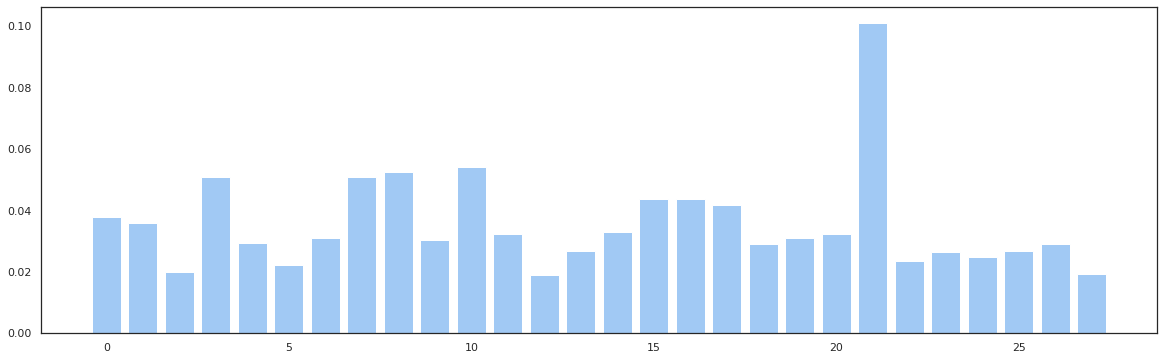

In [439]:
importance=grid_result.best_estimator_.feature_importances_
label_encoded_y_test = LabelEncoder().fit_transform(y_test)
fig, axes = plt.subplots(1, 1, figsize=(20, 6))
axes.bar([x for x in range(len(importance))], importance)
# plt.yscale('log')

plt.show()

# Appendix - I (Experimentation)

## CatBoost without doing ordinal encoding

In [472]:
# Shuffling the data
# master_df_ref=master_df_ref.sample(frac=1.0, random_state=np.random.RandomState(), replace=True)
# master_df_ref.reset_index(drop=True, inplace=True)

X = master_df_ref.drop(columns = ['class'])
y = master_df_ref['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('X shape -', X_train.shape)
print('y shape -', y_train.shape)

#Oversampling
print(Counter(y_train)) # Class distribution
oversample = RandomOverSampler(sampling_strategy='minority')

# Fitting and applying the transforms
X_train, y_train = oversample.fit_resample(X_train, y_train)

# summarize class distribution
print(Counter(y_train))

print('X shape -', X_train.shape)
print('y shape -', y_train.shape)


X shape - (504, 30)
y shape - (504,)
Counter({'Bad': 276, 'Good': 228})
Counter({'Good': 276, 'Bad': 276})
X shape - (552, 30)
y shape - (552,)


In [467]:
# Imputing the training data

X_train['bank_account_duration'].fillna(X_train['bank_account_duration'].mode()[0], inplace=True)
X_train['other_phone_type'].fillna('NA', inplace=True)
X_train['how_use_money'].fillna(X_train['how_use_money'].mode()[0], inplace=True)
# X_train['bank_name'].fillna('NA', inplace=True)

# Encoding categorical variables manually.

X_train['email_duration']=X_train['email_duration'].map({ '3 months or less':1, '4-12 months':2, '1 year or more':3})
X_train['residence_duration']=X_train['residence_duration'].map({'6 months or less':1, '7-12 months':2, '1-2 years':3, '3+ years':4})
X_train['bank_account_duration']=X_train['bank_account_duration'].map({'6 months or less':1, '7-12 months':2, '1-2 years':3, '3+ years':4})
X_train['payment_frequency']=X_train['payment_frequency'].map({'Weekly':1, 'Bi-weekly':2, 'Semi-monthly':3, 'Monthly':4})


In [468]:
# Imputing the testing data

X_test['bank_account_duration'].fillna(X_test['bank_account_duration'].mode()[0], inplace=True)
X_test['other_phone_type'].fillna('NA', inplace=True)
X_test['how_use_money'].fillna(X_test['how_use_money'].mode()[0], inplace=True)
# X_test['bank_name'].fillna('NA', inplace=True)

# Encoding categorical variables manually.

X_test['email_duration']=X_test['email_duration'].map({ '3 months or less':1, '4-12 months':2, '1 year or more':3})
X_test['residence_duration']=X_test['residence_duration'].map({'6 months or less':1, '7-12 months':2, '1-2 years':3, '3+ years':4})
X_test['bank_account_duration']=X_test['bank_account_duration'].map({'6 months or less':1, '7-12 months':2, '1-2 years':3, '3+ years':4})
X_test['payment_frequency']=X_test['payment_frequency'].map({'Weekly':1, 'Bi-weekly':2, 'Semi-monthly':3, 'Monthly':4})



In [469]:
X_train.drop(columns=['email_duration', 'home_phone_type', 'application_when_year', 'email_prov', 'how_use_money', 'other_phone_type'], inplace=True)
X_test.drop(columns=['email_duration', 'home_phone_type', 'application_when_year', 'email_prov', 'how_use_money', 'other_phone_type'], inplace=True)

# first divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()
X_train_bool= X_train.select_dtypes(include = 'bool').copy()

for column in X_train_bool.columns.tolist():
  X_train[column]=X_train[column].astype(int)

X_train.shape

(504, 24)

In [438]:
# !pip install catboost


In [470]:
# Hyper parameter tuning of the CatBoost model using grid_search

# X_train, y_train, X_test, y_test=processed_for_model(PATH, 10, 0.8)
# Counterfactual
# X_train=X_train[ori_df_cols]
# X_test=X_test[ori_df_cols]

from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot

# split data into X and y
X = X_train
y = y_train
# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)

# grid search
cat_features=X_train_cat.columns.tolist()
model = CatBoostClassifier(eta=0.2, max_depth=7, random_state=42) # , cat_features = cat_features

n_estimators = range(200, 310, 20)
# A parameter grid for CatBoost
param_grid = {'n_estimators': n_estimators,
        'eta':[0.3]}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']


0:	learn: 0.6657991	total: 1.78ms	remaining: 426ms
1:	learn: 0.6181796	total: 6.31ms	remaining: 751ms
2:	learn: 0.5822548	total: 10.6ms	remaining: 841ms
3:	learn: 0.5415759	total: 15ms	remaining: 883ms
4:	learn: 0.5142696	total: 19.2ms	remaining: 900ms
5:	learn: 0.4903998	total: 23.4ms	remaining: 911ms
6:	learn: 0.4607345	total: 27.5ms	remaining: 915ms
7:	learn: 0.4424474	total: 31.7ms	remaining: 919ms
8:	learn: 0.4120290	total: 35.9ms	remaining: 921ms
9:	learn: 0.3870755	total: 40.2ms	remaining: 925ms
10:	learn: 0.3790537	total: 44.4ms	remaining: 924ms
11:	learn: 0.3662329	total: 48.6ms	remaining: 923ms
12:	learn: 0.3472928	total: 52.7ms	remaining: 920ms
13:	learn: 0.3341895	total: 56.8ms	remaining: 917ms
14:	learn: 0.3197975	total: 61.1ms	remaining: 916ms
15:	learn: 0.3096489	total: 65.5ms	remaining: 916ms
16:	learn: 0.2994060	total: 69.7ms	remaining: 914ms
17:	learn: 0.2806858	total: 73.9ms	remaining: 912ms
18:	learn: 0.2708906	total: 78.1ms	remaining: 909ms
19:	learn: 0.2619000	tot

F1 score 0.45161290322580644
AUC Score =  0.6134625191228965


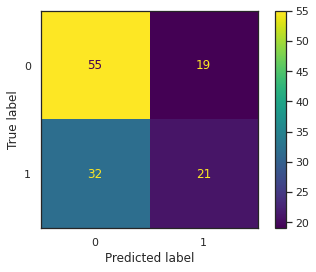

In [471]:
y_pred = grid_result.best_estimator_.predict(X_test)
label_encoded_y_test = LabelEncoder().fit_transform(y_test)
print('F1 score', f1_score(label_encoded_y_test, y_pred))

plot_confusion_matrix(grid_result.best_estimator_, X_test, label_encoded_y_test)  

print('AUC Score = ', roc_auc_score(label_encoded_y_test, grid_result.best_estimator_.predict_proba(X_test)[:, 1]))


## Step 2: Tune max_depth and min_child_weight

In [ ]:

# Hyper parameter tuning of the XGBoost model using grid_search

# grid search
cat_features=X_train_cat.columns.tolist()
model = CatBoostClassifier(n_estimators= 300, eta=0.3, cat_features = cat_features, random_state=42)
# A parameter grid for CatBoost
param_grid = {'random_strength': [0.1, 0.2, 0.3],
              'depth': [10, 12]}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

0:	learn: 0.5484379	total: 118ms	remaining: 35.3s
1:	learn: 0.4330065	total: 223ms	remaining: 33.3s
2:	learn: 0.3483138	total: 329ms	remaining: 32.5s
3:	learn: 0.2915991	total: 432ms	remaining: 32s
4:	learn: 0.2506657	total: 542ms	remaining: 32s
5:	learn: 0.2161692	total: 661ms	remaining: 32.4s
6:	learn: 0.1972277	total: 771ms	remaining: 32.3s
7:	learn: 0.1772955	total: 875ms	remaining: 31.9s
8:	learn: 0.1554417	total: 986ms	remaining: 31.9s
9:	learn: 0.1398384	total: 1.09s	remaining: 31.7s
10:	learn: 0.1265145	total: 1.2s	remaining: 31.5s
11:	learn: 0.1129618	total: 1.3s	remaining: 31.2s
12:	learn: 0.1029298	total: 1.4s	remaining: 30.9s
13:	learn: 0.0934835	total: 1.5s	remaining: 30.7s
14:	learn: 0.0869255	total: 1.61s	remaining: 30.6s
15:	learn: 0.0812364	total: 1.72s	remaining: 30.6s
16:	learn: 0.0755668	total: 1.83s	remaining: 30.5s
17:	learn: 0.0703143	total: 1.94s	remaining: 30.4s
18:	learn: 0.0653199	total: 2.04s	remaining: 30.3s
19:	learn: 0.0618851	total: 2.16s	remaining: 30.2

## Step 3: Tune gamma

In [ ]:
# Hyper paramter tuning of the XGBoost model using grid_search

# grid search
model = XGBClassifier(n_estimators=295, eta=0.001, max_depth=8, min_child_weight=0.2)

# A parameter grid for XGBoost
param_grid = {'gamma': [0.05, 0.1, 0.15, 0.2]}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.767985 using {'gamma': 0.2}


## Step 4: Tune subsample and colsample_bytree

In [ ]:
# Hyper paramter tuning of the XGBoost model using grid_search

# grid search
model = XGBClassifier(n_estimators=295, eta=0.001, max_depth=8, min_child_weight=0.2)

# A parameter grid for XGBoost
param_grid = {'subsample': [0.8, 0.9, 1.0],
              'colsample_bytree': [0.8, 0.9, 1.0, 1.1, 1.2]}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.764158 using {'colsample_bytree': 1.0, 'subsample': 1.0}


## Step 5: Tuning Regularization Parameters

In [ ]:
# Hyper paramter tuning of the XGBoost model using grid_search

# grid search
model = XGBClassifier(n_estimators=295, eta=0.001, max_depth=8, min_child_weight=0.2, subsample=1.0, colsample_bytree=1.0)

# A parameter grid for XGBoost
param_grid = {'reg_alpha':[0.039, 0.04, 0.041]}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.767347 using {'reg_alpha': 0.04}


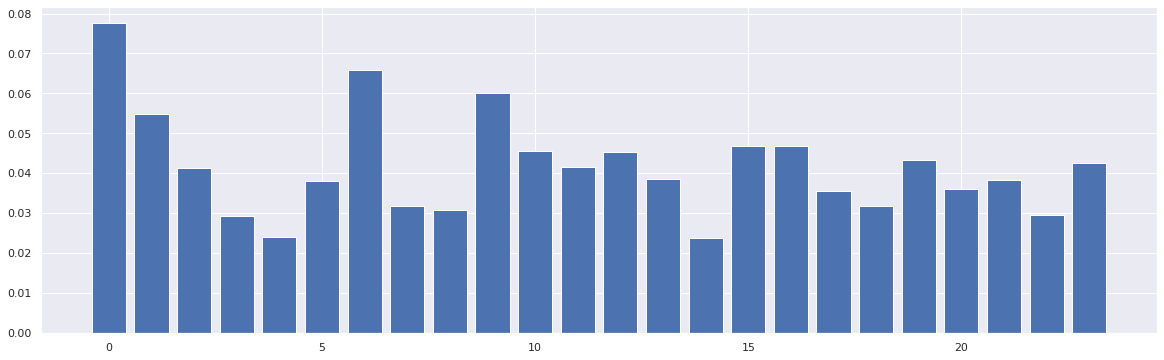

In [ ]:
importance=grid_result.best_estimator_.feature_importances_
label_encoded_y_test = LabelEncoder().fit_transform(y_test)
fig, axes = plt.subplots(1, 1, figsize=(20, 6))
axes.bar([x for x in range(len(importance))], importance)
# plt.yscale('log')

plt.show()

# Appendix - II

## Logistic Regression for Experimentation

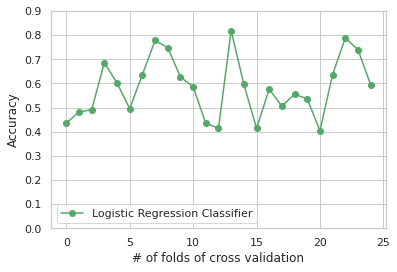

In [143]:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression()
cv_score = cross_val_score(clf, 
                            X_train, y_train,
                            scoring = 'roc_auc',
                            cv = 25,
                            n_jobs = -1,
                            verbose = 0)

plt.plot(cv_score, 'go-',label='Logistic Regression Classifier')
plt.xlabel('# of folds of cross validation')
plt.ylabel('Accuracy')
plt.ylim(0,0.9)
plt.legend()
plt.show()